In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/clear_cloudy_merged/train_C_over"
plot_title = "train_C_over"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.849729,0.8420,0.664406,0.8420,0.700192,0.949649,0.894553,0.915940,0.746995,0.517799
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.862950,0.8515,0.705938,0.8515,0.778883,0.952840,0.920999,0.919693,0.804203,0.586004
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.882275,0.8745,0.741887,0.8745,0.800815,0.962436,0.930991,0.934078,0.823562,0.632674
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.882666,0.8740,0.746248,0.8740,0.814763,0.962634,0.935623,0.933507,0.834558,0.640226
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.878691,0.8690,0.745067,0.8690,0.826625,0.959503,0.936655,0.928228,0.835655,0.638736


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.849729,0.8420,0.664406,0.8420,0.700192,0.949649,0.894553,0.915940,0.746995,0.517799
1,2,test,0.862950,0.8515,0.705938,0.8515,0.778883,0.952840,0.920999,0.919693,0.804203,0.586004
2,3,test,0.882275,0.8745,0.741887,0.8745,0.800815,0.962436,0.930991,0.934078,0.823562,0.632674
3,4,test,0.882666,0.8740,0.746248,0.8740,0.814763,0.962634,0.935623,0.933507,0.834558,0.640226
4,5,test,0.878691,0.8690,0.745067,0.8690,0.826625,0.959503,0.936655,0.928228,0.835655,0.638736


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/400:,Train,Loss,=,1.555,Valid,Loss,=,1.538,ETA,=,6.26h
1,Epoch,"1/40,",Batch,20/400:,Train,Loss,=,1.512,Valid,Loss,=,1.481,ETA,=,5.90h
2,Epoch,"1/40,",Batch,30/400:,Train,Loss,=,1.437,Valid,Loss,=,1.436,ETA,=,5.06h
3,Epoch,"1/40,",Batch,40/400:,Train,Loss,=,1.459,Valid,Loss,=,1.369,ETA,=,5.20h
4,Epoch,"1/40,",Batch,50/400:,Train,Loss,=,1.405,Valid,Loss,=,1.348,ETA,=,4.98h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.555,1.538
20,1,20,1.512,1.481
30,1,30,1.437,1.436
40,1,40,1.459,1.369
50,1,50,1.405,1.348


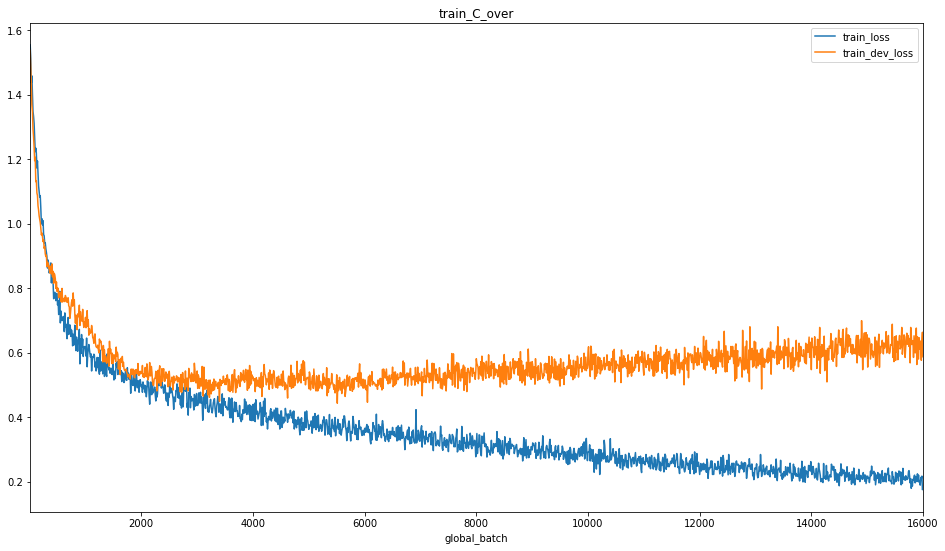

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,1.0325,0.9795
2,0.7085,0.7705
3,0.6060,0.6855
4,0.5455,0.5980
5,0.5170,0.5400


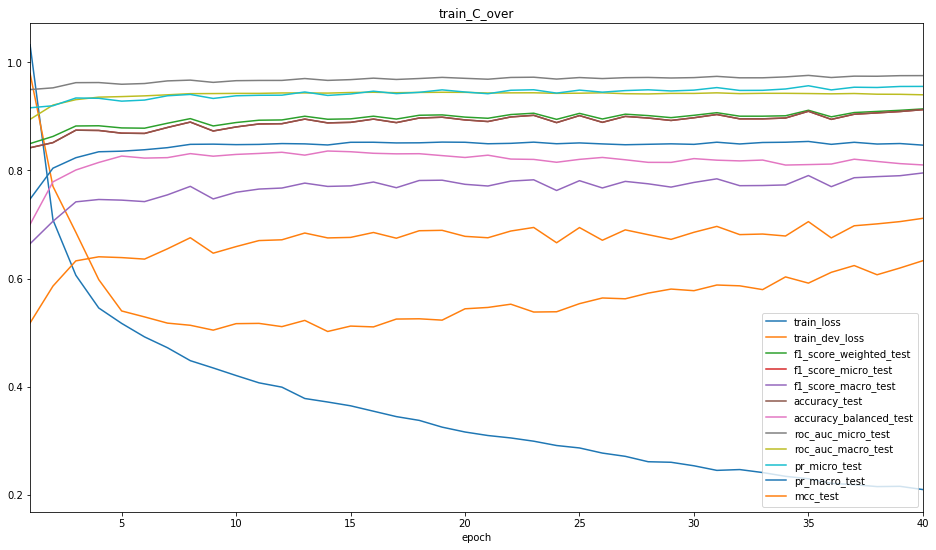

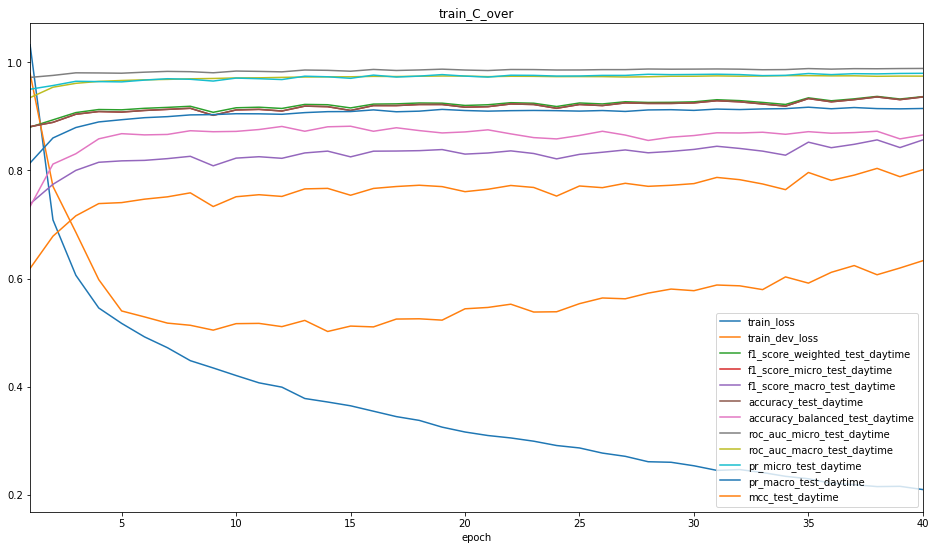

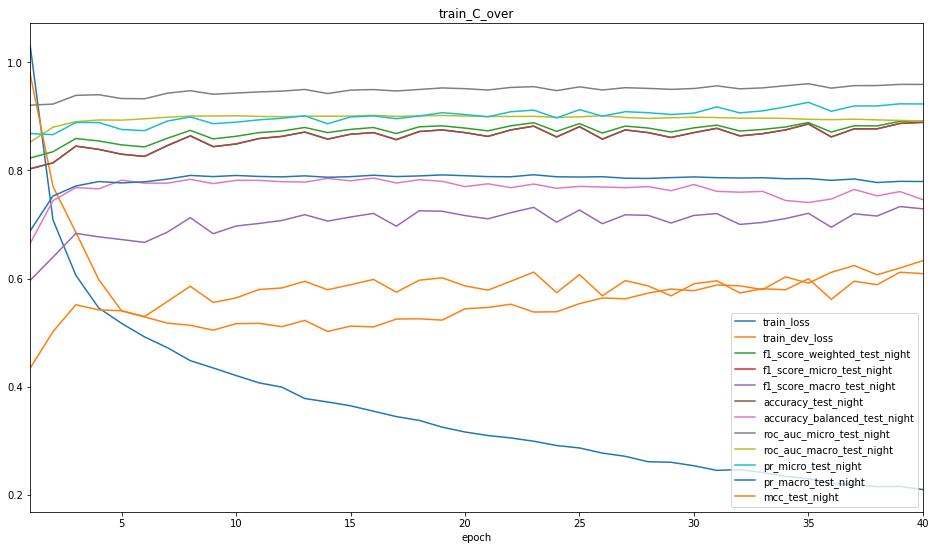

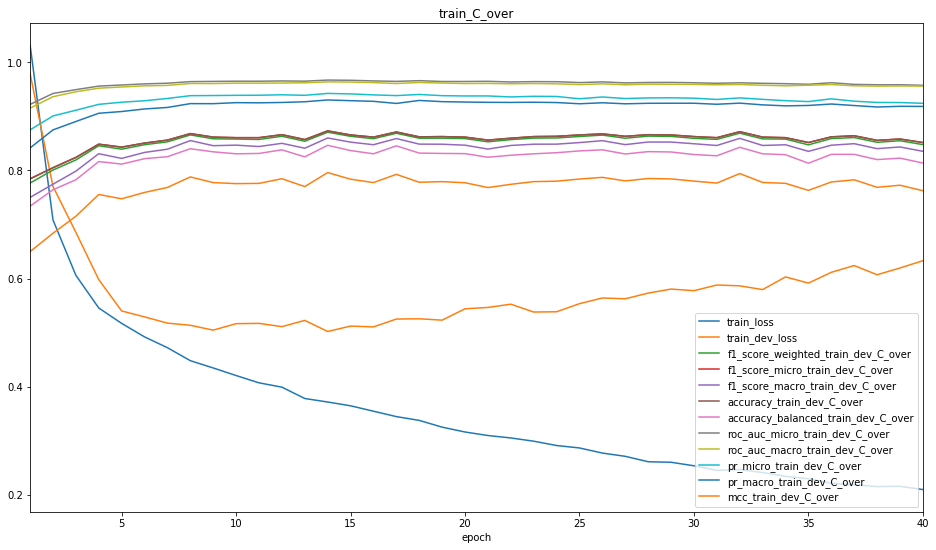

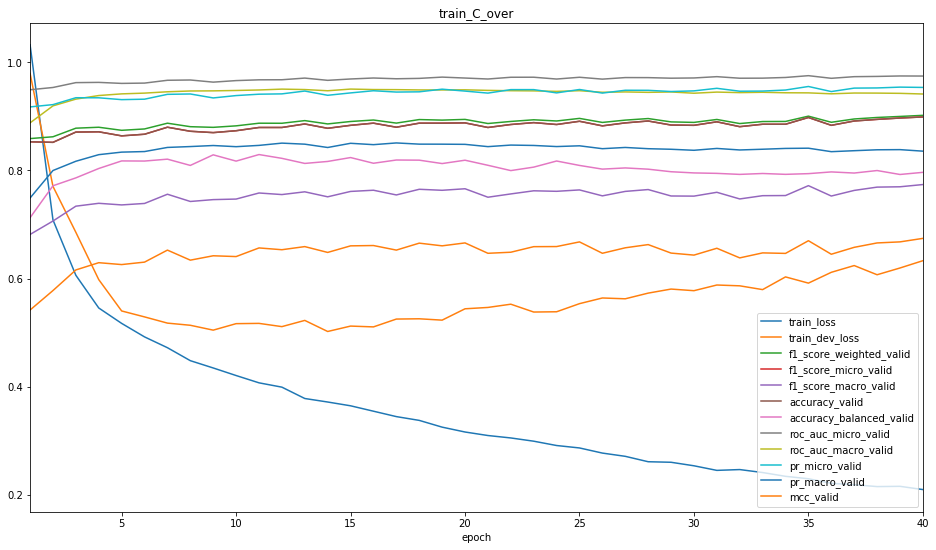

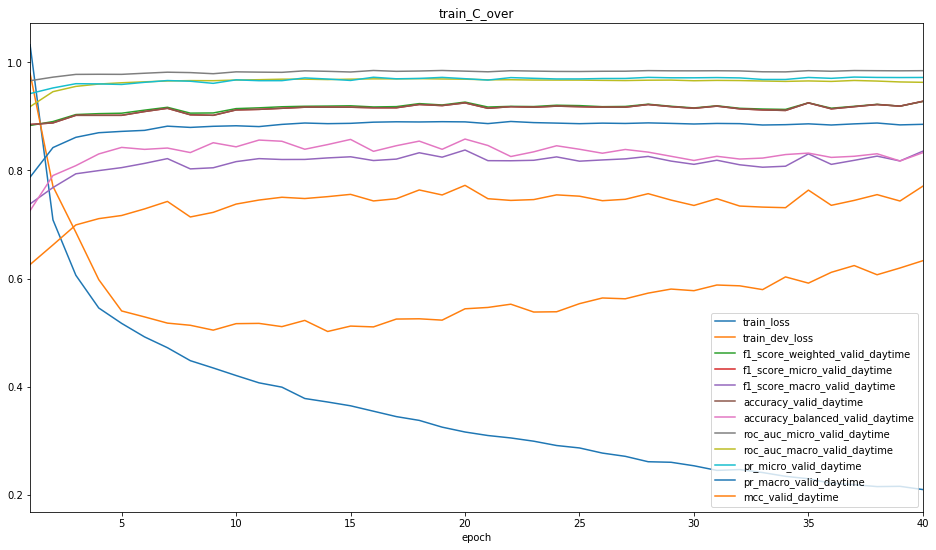

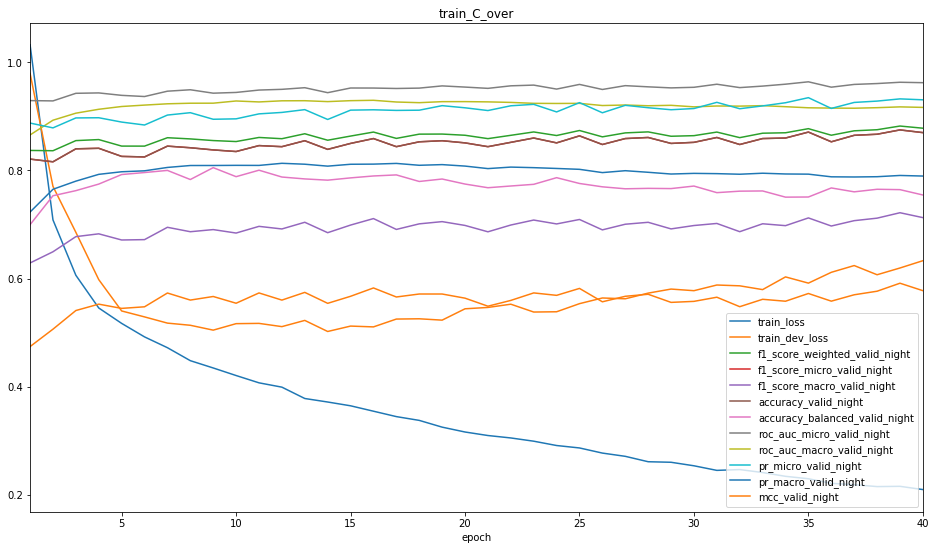

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)